## Save Code Data to CSV

In [2]:
import os
import glob
import csv
import pandas as pd

In [2]:
def save_files_to_csv(repo_path, output_file, extension):
    files = glob.glob(f"{os.path.join(os.getcwd(), repo_path)}/**/*.{extension}", recursive=True)
    if not files:
        print(f"No '{extension}' files found in the directory.")
        return

    with open(output_file, mode='a', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Repo_id', 'File_path', 'Content'])
        
        # Iterate through the files and write their content to the CSV
        for file_name in files:
            file_path = os.path.join(repo_path, file_name)
            with open(file_path, mode='r', encoding='utf-8') as file:
                content = file.read()
                if content.strip() :
                    csv_writer.writerow([repo_path, os.path.join(os.path.basename(repo_path), os.path.relpath(file_path, repo_path)), content])

def remove_duplicates(csv_file) :
    df = pd.read_csv(csv_file)
    df = df.drop_duplicates(subset=['Content'])
    df.to_csv(csv_file, index=False)

In [364]:
REPO1 = "erp-4.1.0-rc5"
REPO2 = "odoo-enterprise"
OUTPUT_PY = 'python_code.csv'
OUTPUT_XML = 'xml_code.csv'
TARGET_EXT = ['py', 'xml']

In [365]:
if os.path.exists("python_code.csv"):
    os.remove("python_code.csv")

if os.path.exists("xml_code.csv"):
    os.remove("xml_code.csv")

In [366]:
# Extract content from HAUERP v4.1.0-rc5 at 26/03/2024
save_files_to_csv(REPO1, OUTPUT_PY, 'py')
save_files_to_csv(REPO1, OUTPUT_XML, 'xml')

In [367]:
# Extract content from Odoo entreprise v15.0 at 26/03/2024
save_files_to_csv(REPO2, OUTPUT_PY, 'py')
save_files_to_csv(REPO2, OUTPUT_XML, 'xml')

In [368]:
df = pd.read_csv("python_code.csv")
print("Number of python codes extracted :", len(df))

df = pd.read_csv("xml_code.csv")
print("Number of xml codes extracted :", len(df))

Number of python codes extracted : 6747
Number of xml codes extracted : 4188


In [369]:
remove_duplicates('python_code.csv')
df = pd.read_csv("python_code.csv")
print("Number of python codes extracted after removing duplicates :", len(df))

remove_duplicates('xml_code.csv')
df = pd.read_csv("xml_code.csv")
print("Number of xml codes extracted after removing duplicates :", len(df))

Number of python codes extracted after removing duplicates : 6180
Number of xml codes extracted after removing duplicates : 4159


In [3]:
df1 = pd.read_csv('python_code.csv')
df2 = pd.read_csv('xml_code.csv')
merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df.to_csv('code.csv', index=False)

In [4]:
import numpy as np

df1['Content_length'] = df1['Content'].apply(len)
print(min(df1['Content_length']))
print(max(df1['Content_length']))
print(np.mean(df1['Content_length']))
sorted_seq_length = np.sort(df1['Content_length'])
print(sorted_seq_length[::-1][:25])
print(df1['Content_length'])

7
342480
3579.3588996763756
[342480 332361 136044 126329 119320 116249 105842 102172  98719  98674
  97981  92881  90509  86549  80695  78819  77205  75211  74921  74093
  73089  72159  67364  67095  66975]
0          21
1         549
2        1500
3       11370
4          79
        ...  
6175       36
6176      619
6177      739
6178    20727
6179      133
Name: Content_length, Length: 6180, dtype: int64


In [ ]:
max_length_index = df1['Content_length'].idxmax()

max_length_content = df1.loc[max_length_index, 'Content']

print("Content of the element with the biggest content length:\n", max_length_content)

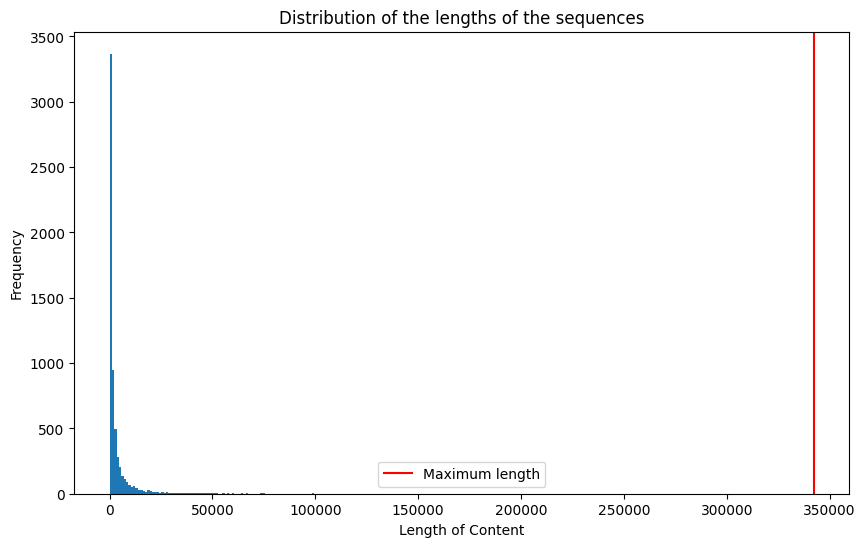

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df1['Content_length'], bins=300)
plt.axvline(max(df1['Content_length']), color='r', label='Maximum length')
plt.title('Distribution of the lengths of the sequences')
plt.xlabel('Length of Content')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
max_length = df1['Content_length'].max()
print(max_length)
max_length_index = df1['Content_length'].idxmax()
print(max_length_index)
max_length_content = df1.loc[max_length_index, 'Content']
print(max_length_content)

In [8]:
from transformers import AutoTokenizer

MODEL = "deepseek-ai/deepseek-coder-6.7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)

C:\Users\AdminLocal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def get_token_seq_length(dataset, tokenizer, data_column):
    seq_length = []
    for content in dataset[data_column]:
        seq_length.append(len(tokenizer(content).tokens()))
    return seq_length

token_seq_length = get_token_seq_length(df1, tokenizer, 'Content')

Token indices sequence length is longer than the specified maximum sequence length for this model (16562 > 16384). Running this sequence through the model will result in indexing errors


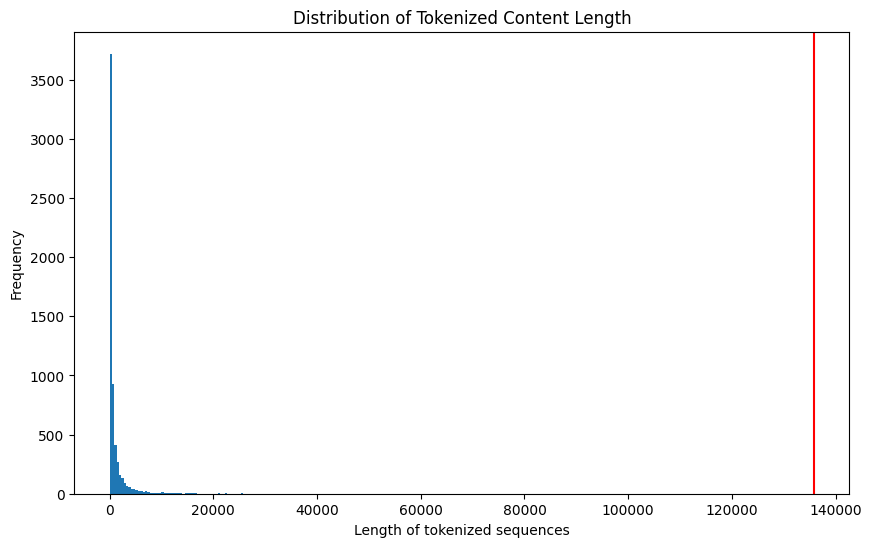

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(token_seq_length, bins=300)
plt.axvline(max(token_seq_length), color='r')
plt.title('Distribution of Tokenized Content Length')
plt.xlabel('Length of tokenized sequences')
plt.ylabel('Frequency')

plt.show()

1023


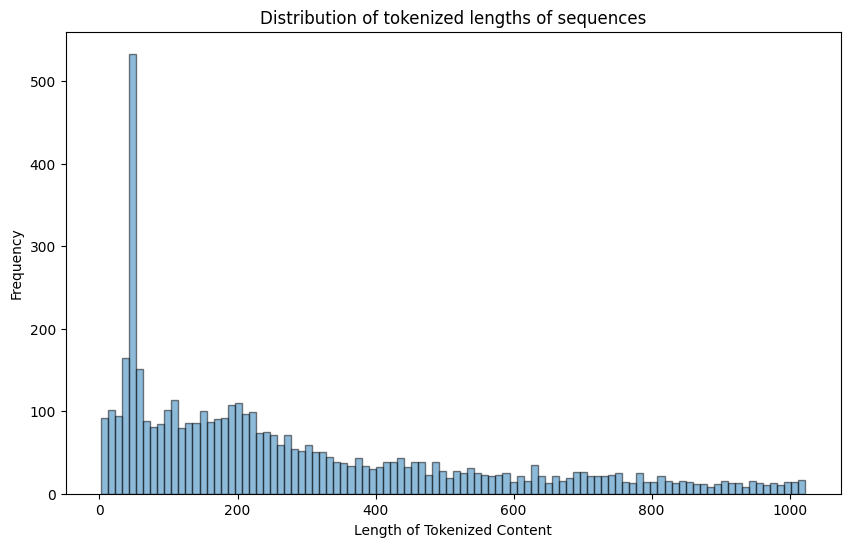

In [11]:
df1['token_length'] = token_seq_length
df_filtered = df1[df1['token_length'] < 1024]

print(max(df_filtered['token_length']))

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['token_length'], bins=100, edgecolor='black', alpha=0.5)
plt.title('Distribution of tokenized lengths of sequences')
plt.xlabel('Length of Tokenized Content')
plt.ylabel('Frequency')
plt.show()

In [12]:
df_python = df_filtered

In [13]:
df_python = df_filtered[['Repo_id', 'File_path', 'Content']]
df_python.to_csv('python_code_filtered.csv', index=False)
df_python.head()

,Repo_id,File_path,Content
0,erp-4.1.0-rc5,erp-4.1.0-rc5\addons\aieg_mig6_accounting_expo...,from . import models\n
1,erp-4.1.0-rc5,erp-4.1.0-rc5\addons\aieg_mig6_accounting_expo...,# Copyright 2022 haulogy\n# Part of haulogy. S...
2,erp-4.1.0-rc5,erp-4.1.0-rc5\addons\aieg_mig6_accounting_expo...,"import logging\n\nfrom odoo import fields, mod..."
4,erp-4.1.0-rc5,erp-4.1.0-rc5\addons\aieg_mig6_accounting_expo...,from . import (\n aieg_mig6_accounting_expo...
5,erp-4.1.0-rc5,erp-4.1.0-rc5\addons\aiesh_mig6_accounting_exp...,# Copyright 2022 haulogy\n# Part of haulogy. S...


In [14]:
df = pd.read_csv("python_code_filtered.csv")
print(len(df))

4790


In [15]:
max(df_filtered['Content_length'])

4255